## Problem Statement

This project aims to forecast sugar prices in Bangladesh using four years of historical time series data. Accurate price predictions can help market participants make better decisions and manage risks. The focus is on building a machine learning model that captures trends and seasonality to provide reliable short-term forecasts.

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



2025-07-30 09:27:52.758325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 09:27:52.759072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 09:27:52.762027: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 09:27:52.767072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753846072.774248  263739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753846072.77

In [273]:
df = pd.read_csv('data/sugar_prices.csv')
df.head()

,Date,category,item,unit,min_price,max_price
0,2021-05-17,Miscellaneous,Sugar,per kg,70,75
1,2021-05-18,Miscellaneous,Sugar,per kg,70,75
2,2021-05-20,Miscellaneous,Sugar,per kg,70,75
3,2021-05-21,Miscellaneous,Sugar,per kg,70,75
4,2021-05-22,Miscellaneous,Sugar,per kg,70,75


The data has 6 columns:
- **Date**: the date prices were collected on
- **category**: the category of the item
- **item**: the item name
- **unit**: unit of measure
- **min_price**: minimum price found on the day
- **max_price**: maximum price found on the day

## Splitting into train and test dataset

In [274]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

## Data Inspaction

### Checking null values

In [275]:
for col in train.columns:
    print(f"{col}: {train[col].isna().sum()} null values")

category: 0 null values
item: 0 null values
unit: 0 null values
min_price: 0 null values
max_price: 0 null values


The columns don't contain any null values

### Checking data types

In [276]:
for col in train.columns:
    print(f"{col}: {train[col].dtype}")

category: object
item: object
unit: object
min_price: int64
max_price: int64


**Observations**
- **Date** column seems to be of object type, should be converted to datetime and set as index type for better analysis
- All other columns have proper types

In [277]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2021-05-17 to 2024-11-14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   768 non-null    object
 1   item       768 non-null    object
 2   unit       768 non-null    object
 3   min_price  768 non-null    int64 
 4   max_price  768 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 36.0+ KB


### checking unique values in categorical columns

In [278]:
cat_cols = [col for col in train.columns if train[col].dtype == 'O']

for col in cat_cols:
    unq_vals = train[col].unique()
    print(f"Column col has {len(unq_vals)} unique values:")
    for val in unq_vals:
        print(val)

Column col has 1 unique values:
Miscellaneous
Column col has 1 unique values:
Sugar
Column col has 1 unique values:
per kg


- categorical columns all hold the same values and don't provide any useful information. so they all could be dropped.
- the unit information can be kept by changing the column names for numeric columns to include unit

In [279]:
train.rename(columns={
    'min_price': 'min_price_per_kg',
    'max_price': 'max_price_per_kg'
}, inplace=True)

train.drop(columns=cat_cols, inplace=True)

/tmp/ipykernel_263739/2246083206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={
/tmp/ipykernel_263739/2246083206.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=cat_cols, inplace=True)


In [280]:
train.head()

,min_price_per_kg,max_price_per_kg
Date,,
2021-05-17,70,75
2021-05-18,70,75
2021-05-20,70,75
2021-05-21,70,75
2021-05-22,70,75


### Inspecting numerical columns 

In [281]:
num_cols = ['min_price_per_kg', 'max_price_per_kg']

train[num_cols].describe()

,min_price_per_kg,max_price_per_kg
count,768.000000,768.000000
mean,111.809896,118.356771
std,25.423101,27.252651
min,68.000000,70.000000
25%,78.000000,80.000000
50%,125.000000,135.000000
75%,130.000000,140.000000
max,145.000000,150.000000


No unusual values detected in the numerical columns

## Data Analysis

### Primary Inspection

<Axes: xlabel='Date'>

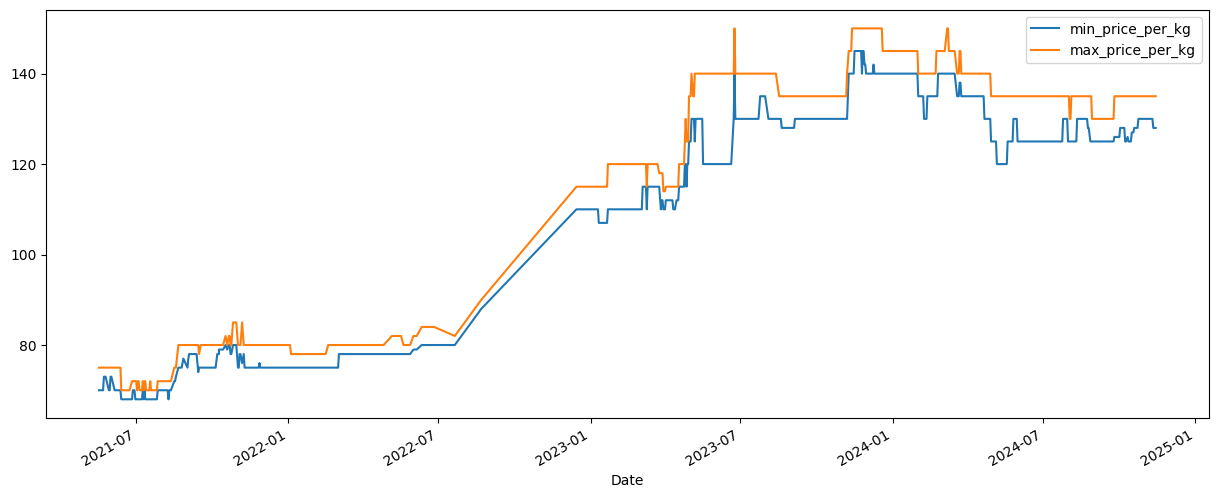

In [282]:
train.sort_index(inplace=True)

train[num_cols].plot(figsize=(15, 6))

- Data seemes to be jerky at daily level
- Smoothing out the data by taking weekly and monthly rolling averages could reveal better trends

### Weekly rolling avarage

<Axes: xlabel='Date'>

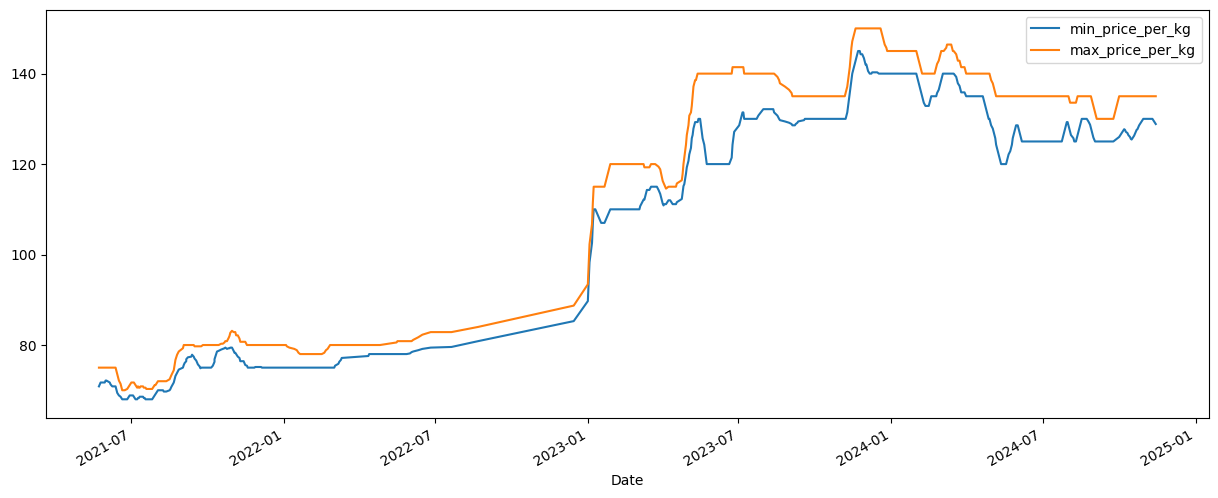

In [283]:
train[num_cols].rolling(window=7).mean().plot(figsize=(15, 6))

### Monthly rolling avarage

<Axes: xlabel='Date'>

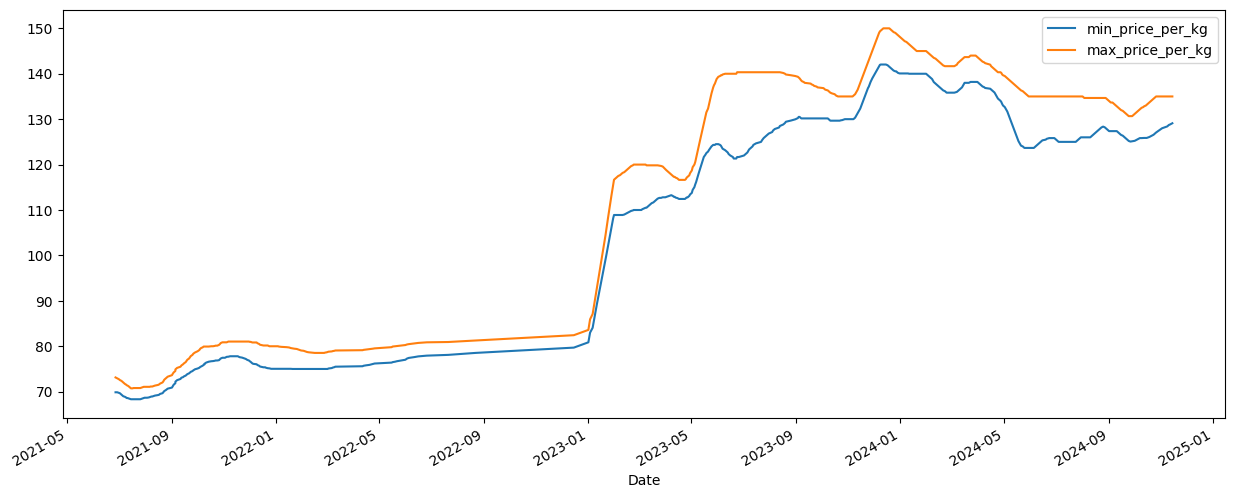

In [284]:
train[num_cols].rolling(window=30).mean().plot(figsize=(15, 6))

### Checking for trend, seasonality and residuals 

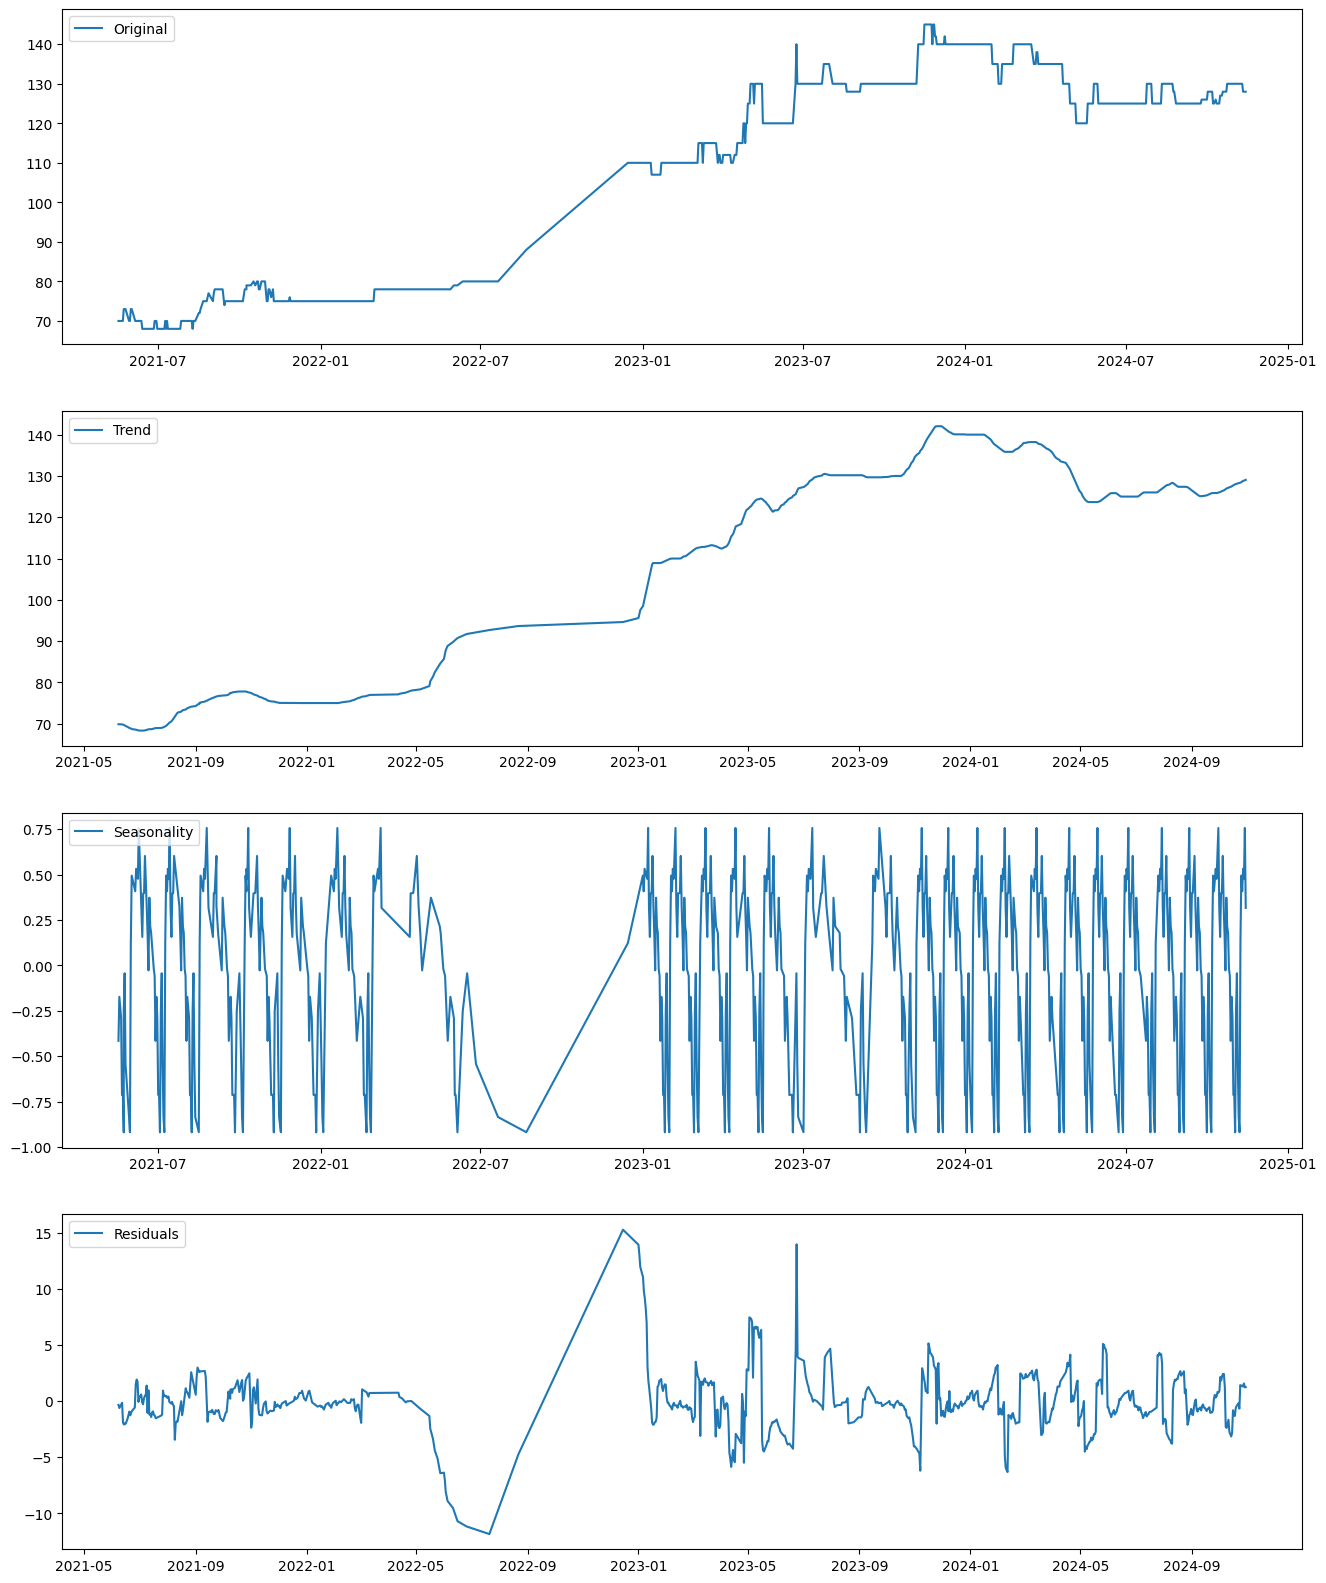

In [285]:
decomsition_additive = seasonal_decompose(train['min_price_per_kg'], model='additive', period=30)

trend_additive = decomsition_additive.trend
seasonal_additive = decomsition_additive.seasonal
residual_additive = decomsition_additive.resid

plt.figure(figsize=(16, 20))

plt.subplot(411)
plt.plot(train['min_price_per_kg'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend_additive, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual_additive, label='Residuals')
plt.legend(loc='upper left')

- data shows a general upward trend
- data shows seasonal trend except for the time from **2022-06 to 2023-01**
- residuals are mostly constant except for the time **2022-06 to 2023-01**

### Autocorelation plot

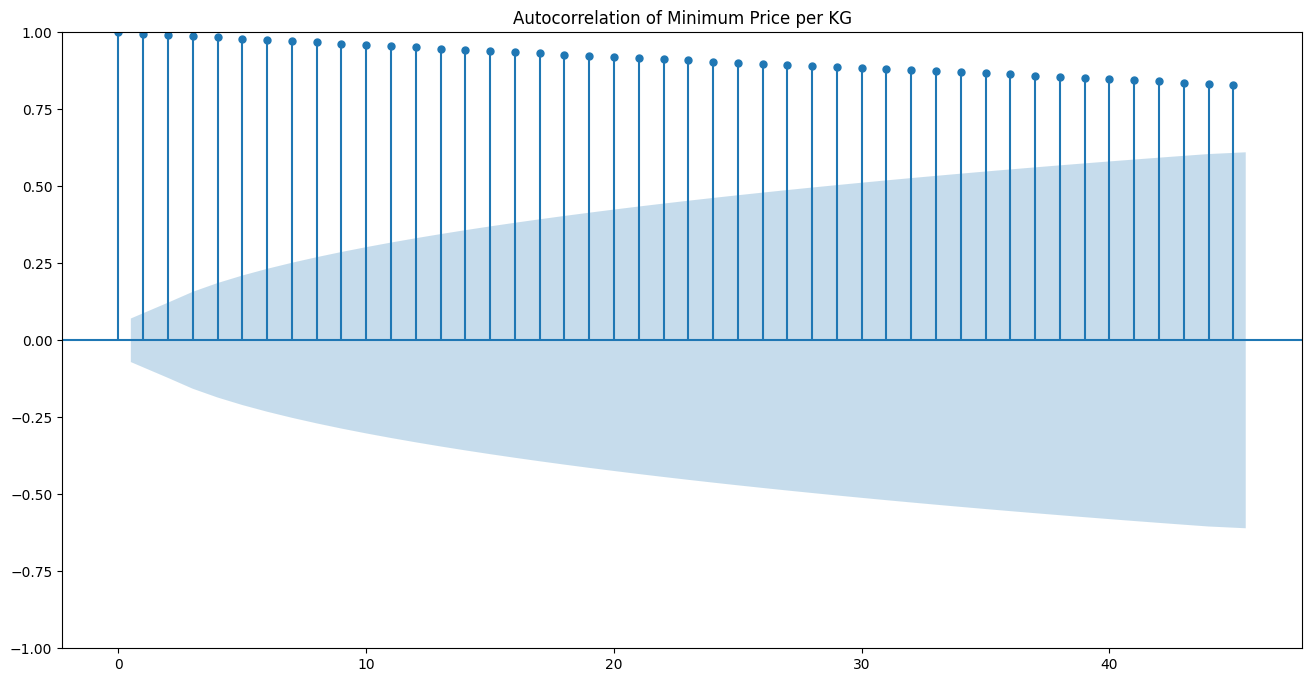

In [286]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_acf(train['min_price_per_kg'].dropna(), lags=45, ax=ax)
plt.title('Autocorrelation of Minimum Price per KG')
plt.show()

- acf plot makes the seasonality more certain

In [287]:
result = adfuller(train['min_price_per_kg'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.5424881128193522
p-value: 0.5123982586120172


- dicky fuller test p-value is greater than 0.05

/tmp/ipykernel_263739/933671054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['diff_price'] = train['min_price_per_kg'].diff()


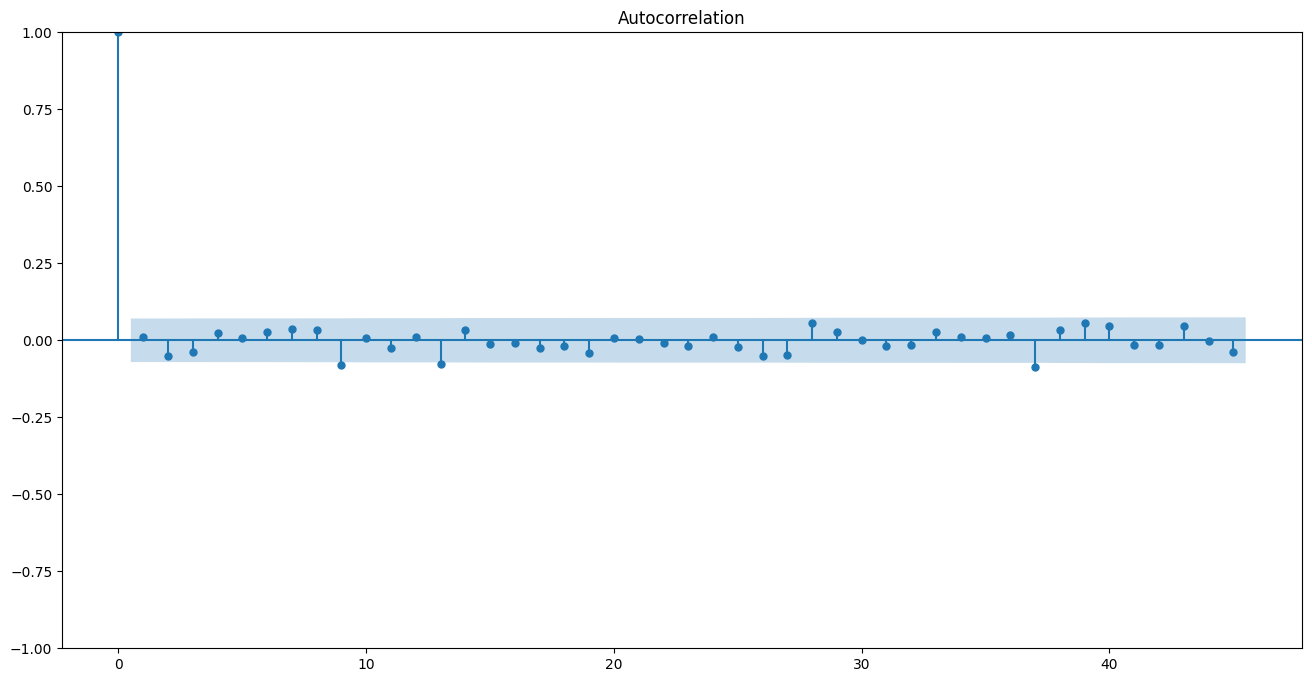

In [288]:
train['diff_price'] = train['min_price_per_kg'].diff()

fig, ax = plt.subplots(figsize=(16, 8))
plot_acf(train['diff_price'].dropna(), lags=45, ax=ax)
plt.show()

### Partial autocorrelation plot

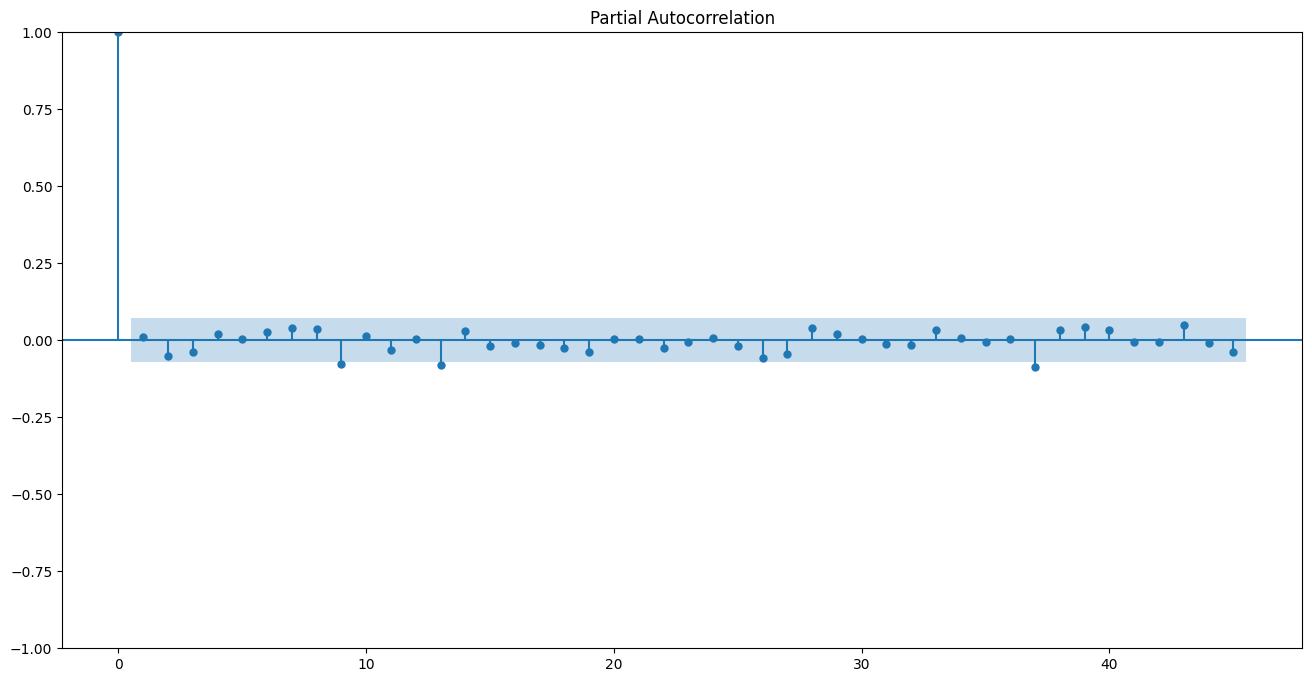

In [289]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_pacf(train['diff_price'].dropna(), lags=45, ax=ax)
plt.show()

## ARIMA Model
Now let's build a basic ARIMA model for sugar price forecasting.

In [290]:
test.rename(columns={
    'min_price': 'min_price_per_kg',
    'max_price': 'max_price_per_kg'
}, inplace=True)



/tmp/ipykernel_263739/766757267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={


ARIMA RMSE: 13.49
ARIMA MAE: 12.08


/home/zishan/Documents/projects/commodity_price_prediction_bd/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zishan/Documents/projects/commodity_price_prediction_bd/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zishan/Documents/projects/commodity_price_prediction_bd/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/zishan/Documents/projects/commodity_price_prediction_bd/venv/lib/python3.12/s

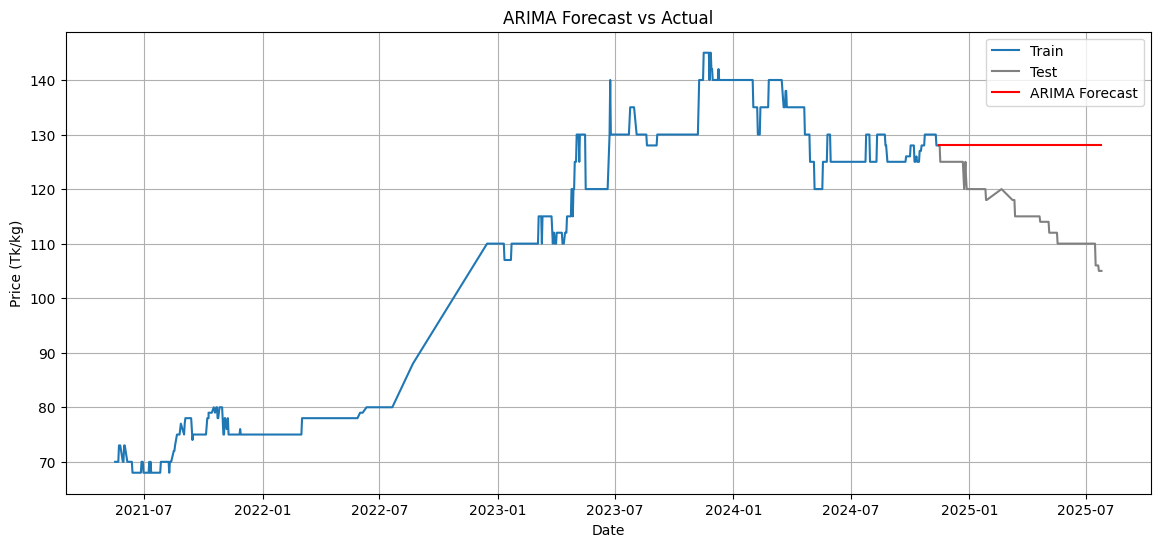

In [291]:

model = ARIMA(train['min_price_per_kg'], order=(1,1,0))
model_fit = model.fit()

forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

true_values = test['min_price_per_kg'].values
rmse_arima = np.sqrt(mean_squared_error(true_values, forecast))
mae_arima = mean_absolute_error(true_values, forecast)

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE: {mae_arima:.2f}")

forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index 

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['min_price_per_kg'], label='Train')
plt.plot(test.index, test['min_price_per_kg'], label='Test', color='gray')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (Tk/kg)')
plt.legend()
plt.grid(True)
plt.show()


### SARIMA MODEL


Best SARIMA Order: (1, 1, 1)
Best Seasonal Order: (0, 1, 0, 12)
Best SARIMA RMSE: 5.04
Best SARIMA MAE: 3.93
Best SARIMA MAPE: 3.51%


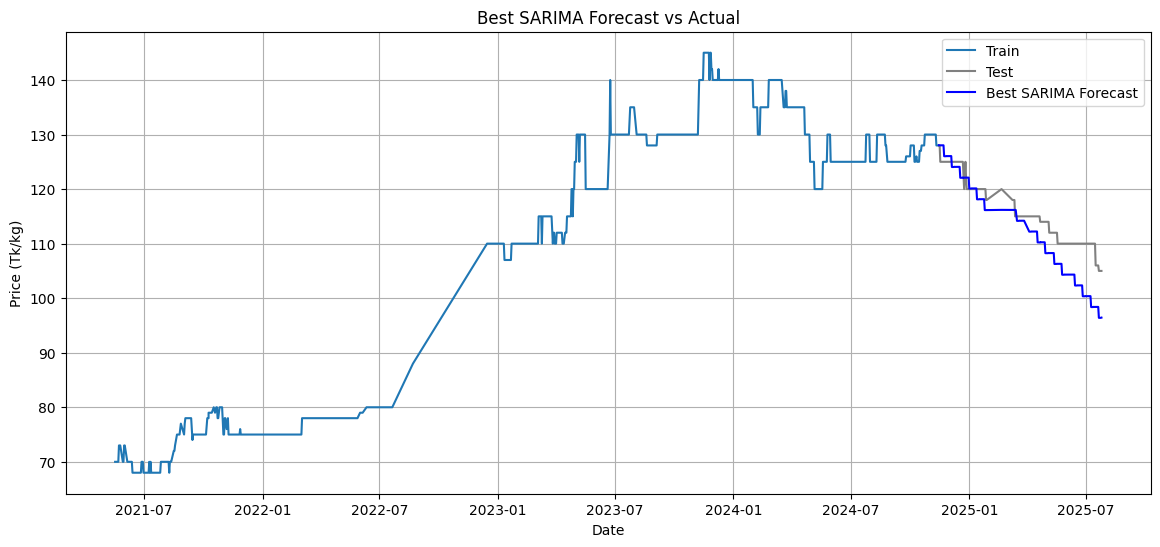

In [300]:
warnings.filterwarnings("ignore")

# Define SARIMA parameter grid
p = d = q = range(0, 2)  # (0, 1)
P = D = Q = range(0, 2)  # (0, 1)
s = 12  # Seasonality (adjust if your data is daily with weekly patterns, use s=7)

best_rmse = float("inf")
best_order = None
best_seasonal_order = None
best_model = None
best_forecast = None

for param in [(x, 1, y) for x in p for y in q]:  # keep d=1
    for seasonal_param in [(x, 1, y, s) for x in P for y in Q]:  # keep D=1
        try:
            model = SARIMAX(train['min_price_per_kg'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test['min_price_per_kg'], forecast))

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results
                best_forecast = forecast

        except Exception as e:
            continue

# Set index for forecast
best_forecast.index = test.index

mae_sarima = mean_absolute_error(test['min_price_per_kg'], best_forecast)
mape_sarima = mean_absolute_percentage_error(test['min_price_per_kg'], best_forecast) * 100  # in %

# Print all metrics
print(f"\nBest SARIMA Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")
print(f"Best SARIMA RMSE: {best_rmse:.2f}")
print(f"Best SARIMA MAE: {mae_sarima:.2f}")
print(f"Best SARIMA MAPE: {mape_sarima:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['min_price_per_kg'], label='Train')
plt.plot(test.index, test['min_price_per_kg'], label='Test', color='gray')
plt.plot(test.index, best_forecast, label='Best SARIMA Forecast', color='blue')
plt.title('Best SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (Tk/kg)')
plt.legend()
plt.grid(True)
plt.show()


### LSTM MODEL

Epoch 1/30


E0000 00:00:1753846085.908171  263739 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753846085.909000  263739 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0676 - val_loss: 0.0013
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 4.9210e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 4.2186e-04
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 6.6929e-04
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 2.5463e-04
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 1.8851e-04
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 1.9381e-04
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 2.3644e-04
Epoch 9/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 2.0562e-04
Epoch 10/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 2.4283e-04
Epoch 11/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 2.5993e-04
Epoch 12/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

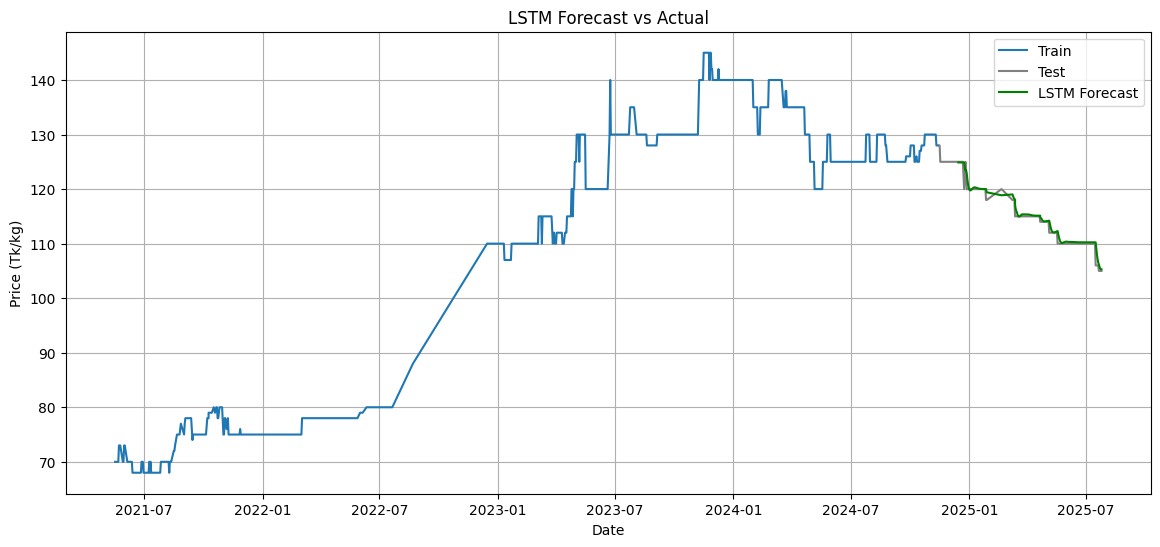

In [303]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['min_price_per_kg']])
scaled_test = scaler.transform(test[['min_price_per_kg']])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30

X_train, y_train = create_sequences(scaled_train, window_size)
X_test, y_test = create_sequences(scaled_test, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(64, activation='relu', return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
y_true = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, predictions))
mae = mean_absolute_error(y_true, predictions)
mape = mean_absolute_percentage_error(y_true, predictions) * 100

print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")

prediction_index = test.index[window_size:]  # because sequences skip first few days

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['min_price_per_kg'], label='Train')
plt.plot(test.index, test['min_price_per_kg'], label='Test', color='gray')
plt.plot(prediction_index, predictions, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (Tk/kg)')
plt.legend()
plt.grid(True)
plt.show()
